In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns
from datetime import date
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from sqlalchemy import cast, Date

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [3]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect the data

In [8]:
inspector = inspect(engine)

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

Last 12 months of precipitioan

In [13]:
# Find date to start query from
#pd.to_datetime used to convert last_date to a timestamp format, then pd.DateOffset used to subtract a year.  Documentation can be found at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html
year_ago = (pd.to_datetime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])\
            - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
year_ago

'2016-08-23'

In [14]:
# Query precipitation for 12 month period
precp_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

In [15]:
#See data
print(precp_year[0])

('2016-08-23', 0.0)


In [16]:
# Plot precipitation data
precp_df = pd.DataFrame(precp_year, columns=['Date', 'Precipitation'])
precp_df = precp_df.dropna()

In [17]:
precp_df['Date'] = pd.to_datetime(precp_df['Date'])

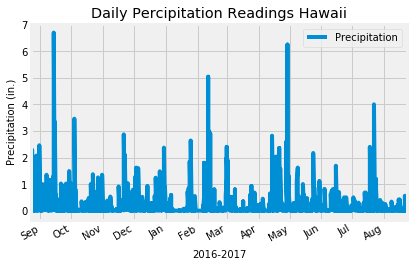

In [18]:
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots()
ax.plot('Date', 'Precipitation', data=precp_df)
ax.legend(loc='best')
ax.set_title('Daily Percipitation Readings Hawaii')
ax.set_ylabel('Precipitation (in.)', fontsize=10)
ax.text(0.5, -0.18, '2016-2017', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# round to nearest years.
datemin = np.datetime64(precp_df['Date'][0], 'm') - np.timedelta64(1, 'm')
datemax = np.datetime64(precp_df['Date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
fig.autofmt_xdate()

plt.show()

x-axis month ticks was accomplished by importing matplotlib.dates and documentation found at https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Precipitation data statistics

In [20]:
precp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
station_count_s = session.query(Station.id).count()
print(f"There are {station_count_s} stations available in the Station dataset.")
station_count_m = session.query(distinct(Measurement.station)).count()
print(f"There are {station_count_m} stations available in the Measurment dataset.")

There are 9 stations available in the Station dataset.
There are 9 stations available in the Measurment dataset.


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Using a session query

In [23]:

station_freq = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

Using a dataframe which I think looks better

In [24]:
station_freq = session.query(Measurement.station).all()
station_freq_df = pd.DataFrame(station_freq, columns=['Station'])
station_freq_df = pd.value_counts(station_freq_df.Station).to_frame().reset_index()
station_freq_df.columns = ['Station ID', 'Report Count']
station_freq_df

,Station ID,Report Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


Lowest temerature recoded

In [26]:
station_temp_lo = session.query(Measurement.station, Measurement.date, Measurement.tobs).order_by(Measurement.tobs).first()
print(f"The lowset temerature recoded in the dataset is {station_temp_lo.tobs}\u00B0F recorded at station\
 {station_temp_lo.station} on {station_temp_lo.date}.")

The lowset temerature recoded in the dataset is 53.0°F recorded at station USC00511918 on 2013-04-02.


Highest temperature recorded

In [27]:
station_temp_lo = session.query(Measurement.station, Measurement.date, func.min(Measurement.tobs)).all()
station_temp_lo

print(f"The highest temerature recoded in the dataset is {func.max(Measurement.tobs)}\u00B0F recorded at station\
# {station_temp_lo.station} on {station_temp_lo.date}.")

AttributeError: 'list' object has no attribute 'station'

Average temperature at the most active station.

In [28]:
station_freq = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
station_active = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_active.station).all()
avg_temp = list(np.ravel(avg_temp[0]))
print(f"The average temperature at the most active weather station ({station_active.station}) \
    is {avg_temp[0].astype(float).round(1)}\u00B0F.")

The average temperature at the most active weather station (USC00519281)     is 71.7°F.


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


Station with highest number of temperature observations

In [31]:
#Find most active station for tobs
station_temp_active = session.query(Measurement.station, func.count(Measurement.tobs))\
    .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
station_temp_active


('USC00519281', 2772)

In [32]:
#Find the latest date in the data set
last_date_temp = session.query(Measurement.date).order_by(Measurement.date.desc())\
    .filter(Measurement.station == station_temp_active.station).first()
last_date_temp

('2017-08-18')

In [33]:
#Year ago date
year_ago_temp = dt.date(2016, 8, 18)

# Query precipitation for 12 month period
temp_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago_temp).filter(Measurement.station == station_temp_active.station).order_by(Measurement.date).all()
temp_year

[(80.0),
 (79.0),
 (81.0),
 (79.0),
 (78.0),
 (77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 

In [34]:
temp_df = pd.DataFrame(temp_year, columns=['Temperature'])
temp_df.describe()

,Temperature
count,357.000000
mean,73.196078
std,4.759460
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


<function matplotlib.pyplot.show(*args, **kw)>

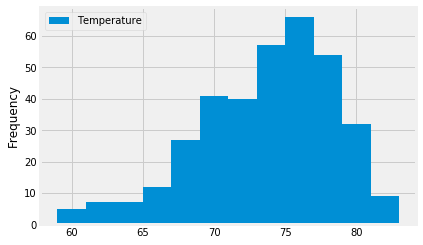

In [35]:
temp_df.plot.hist(bins=12)
plt.show

![precipitation](Images/station-histogram.png)

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d

    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
calc_temps('2012-02-28', '2012-03-05')




[(62.0, 69.57142857142857, 74.0)]

In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2016-11-24', '2016-11-30')
print(f"The minimum temperature recorded {results[0][0]}\u00B0F \nThe average temperature of recoded values was {np.ravel(results[0][1])[0].astype(float).round(1)}\u00B0F\nThe maximum temperature recorded was {results[0][2]}\u00B0F")

The minimum temperature recorded 67.0°F 
The average temperature of recoded values was 74.1°F
The maximum temperature recorded was 78.0°F


In [38]:
temp_min = session.query(func.min(Measurement.tobs)).filter(Measurement.date >= start_date).all()


NameError: name 'start_date' is not defined

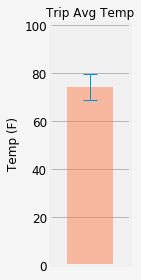

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = ((results[0][2] - results[0][0])/2)
#yerr = (20)
fig = plt.figure(figsize=(2, 4))
fig.set_facecolor('whitesmoke')
ax = plt.axes()
plt.bar(0, results[0][1], color='coral', alpha = .5)
plt.errorbar(0, results[0][1], yerr=yerr, elinewidth=1, capsize=7)
ax.yaxis.grid(color='grey', linestyle='-', linewidth=.5)
ax.xaxis.grid()
plt.ylim(0, 101)
plt.xlim(-.7, .7)
plt.ylabel("Temp (F)", size=12)
plt.xticks([])
plt.yticks(size=12)
plt.title("Trip Avg Temp", size=12)
plt.tight_layout()
plt.show()

In [40]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-11-24'
end_date = '2016-11-30'
station_rain = session.query(Station.name, Measurement.station).all()
station_rain_df = pd.DataFrame(station_rain, columns=['Station', 'Total Rain (in)'])
station_rain_df = station_rain_df.dropna()
station_rain_df


,Station,Total Rain (in)
0,"WAIKIKI 717.2, HI US",USC00519397
1,"WAIKIKI 717.2, HI US",USC00519397
2,"WAIKIKI 717.2, HI US",USC00519397
3,"WAIKIKI 717.2, HI US",USC00519397
4,"WAIKIKI 717.2, HI US",USC00519397
5,"WAIKIKI 717.2, HI US",USC00519397
6,"WAIKIKI 717.2, HI US",USC00519397
7,"WAIKIKI 717.2, HI US",USC00519397
8,"WAIKIKI 717.2, HI US",USC00519397
9,"WAIKIKI 717.2, HI US",USC00519397


In [42]:
def calc_prcp(start_date, end_date):
    sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    station_rain = session.query(*sel).group_by(Measurement.station).filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).filter(Station.station == Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
    station_rain_df = pd.DataFrame(station_rain, columns=['Station Name', 'Latitude', 'Longitude', 'Elevation', 'Precipitation (in)'])
    station_rain_df = station_rain_df.dropna()
    return station_rain_df

In [43]:
calc_prcp('2016-11-24', '2016-11-30')

,Station Name,Latitude,Longitude,Elevation,Precipitation (in)
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.02
1,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.75
2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.47
3,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.41
4,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.30
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12


## Optional Challenge Assignment

In [44]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [128]:


def daily_normals(start_date, end_date):
    daily_norm = []  
    while pd.to_datetime(start_date) < pd.to_datetime(end_date):
        filter_date = pd.to_datetime(start_date).strftime("%m-%d")
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        daily_norm_new = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == filter_date).all()
        
        for min, avg, max in daily_norm_new:
                daily_dict = {}
                daily_dict["Date"] = pd.to_datetime(start_date).strftime("%m-%d")
                daily_dict["Min Temp (F)"] = min
                daily_dict["Avg Temp (F)"] = round(avg,1)
                daily_dict["Max TEmp (F)"] = max
                daily_norm.append(daily_dict)
        
        start_date = pd.to_datetime(start_date) + dt.timedelta(days=1)
    daily_norm_df = pd.DataFrame(daily_norm)
    daily_norm_df = daily_norm_df.set_index('Date')
    return daily_norm_df
#next_day = pd.to_datetime(start_date) + dt.timedelta(days=1)
#next_day

In [129]:
while pd.to_datetime(start_date) < pd.to_datetime(end_date):
    print("One more day")
    start_date = pd.to_datetime(start_date) + dt.timedelta(days=1)

In [130]:
trip_normals = daily_normals("2016-11-24", "2016-11-30")
trip_normals

,Avg Temp (F),Max TEmp (F),Min Temp (F)
Date,,,
11-24,72.6,77.0,66.0
11-25,72.4,78.0,63.0
11-26,73.5,78.0,67.0
11-27,73.0,78.0,63.0
11-28,72.8,80.0,62.0
11-29,71.0,79.0,62.0


(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

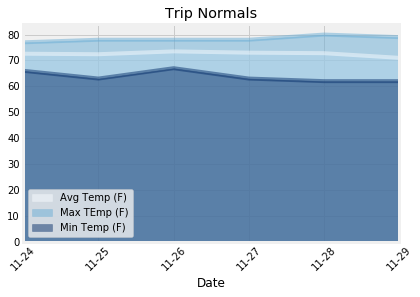

In [143]:
trip_normals.plot(kind='area', stacked=False, alpha=0.5, colormap='Blues',
        title='Trip Normals')
plt.xticks(rotation=45)

In [132]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


ValueError: Input passed into argument "'y1'"is not 1-dimensional.

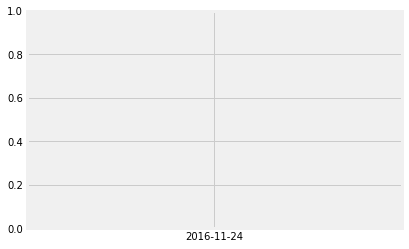

In [112]:
# Plot the daily normals as an area plot with `stacked=False`
# Your x and y axis
x=trip_normals['Date']
y=[ trip_normals['Min'], trip_normals['Avg'], trip_normals['Max'] ]
 
# Basic stacked area chart.
plt.fill_between(x,y, labels=['A','B','C'])
plt.legend(loc='upper left')
plt.show()
 
